<a href="https://colab.research.google.com/github/elisasmenendez/ds-taxi-nyc/blob/master/taxi_nyc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initializing

Download the data to the local VM

In [ ]:
!wget https://s3.amazonaws.com/data-sprints-eng-test/data-sample_data-nyctaxi-trips-2009-json_corrigido.json
!wget https://s3.amazonaws.com/data-sprints-eng-test/data-sample_data-nyctaxi-trips-2010-json_corrigido.json
!wget https://s3.amazonaws.com/data-sprints-eng-test/data-sample_data-nyctaxi-trips-2011-json_corrigido.json
!wget https://s3.amazonaws.com/data-sprints-eng-test/data-sample_data-nyctaxi-trips-2012-json_corrigido.json
# !wget https://s3.amazonaws.com/data-sprints-eng-test/data-vendor_lookup-csv.csv
# !wget https://s3.amazonaws.com/data-sprints-eng-test/data-payment_lookup-csv.csv

Do some imports

In [2]:
import pandas as pd 
import glob
import numpy as np
import matplotlib.pyplot as plt
import datetime

Load all files into a single DataFrame

In [3]:
all_files = glob.glob("*.json") 
df_files = (pd.read_json(f, lines=True) for f in all_files)
df = pd.concat(df_files, ignore_index=True)

Parse datetimes

In [4]:
df = df.assign(pickup_datetime=pd.DatetimeIndex(df['pickup_datetime']))
df = df.assign(dropoff_datetime=pd.DatetimeIndex(df['dropoff_datetime']))

#1 - Average Distance

What is the average distance traveled by trips with a maximum of 2 passengers

In [5]:
data = df.loc[df['passenger_count'] <= 2]
data['trip_distance'].mean()

2.6625269962030926

#2 - Biggest Vendors

Which are the 3 biggest vendors based on the total amount of money raised

In [6]:
data = df[['vendor_id','total_amount']].groupby('vendor_id').sum().reset_index()
data = data.sort_values(by=['total_amount'])[1:4]

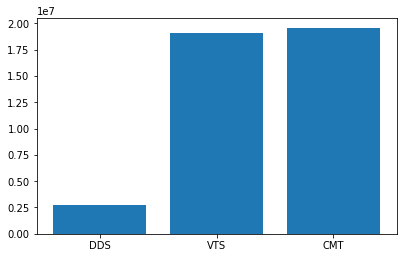

In [8]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(data['vendor_id'], data['total_amount'])
plt.rcParams["figure.figsize"] = (5,3)
plt.show()

#3 - Rides with Cash

Make a histogram of the monthly distribution over 4 years of rides paid with cash

In [9]:
def plotMonthlyDistributionByYear(data, year, top_limit):
  
  # Filter rides by year and get the months from pickup dates
  years = data.loc[data['pickup_datetime'].dt.year  == year] 
  months = years['pickup_datetime'].dt.month

  # Set the x-axis with short names for all months
  fig, ax = plt.subplots()
  bins = np.arange(1,14)
  ax.hist(months, bins = bins, edgecolor="k", align='left')
  ax.set_xticks(bins[:-1])
  ax.set_xticklabels([datetime.date(1900,i,1).strftime('%b') for i in bins[:-1]] )
  
  # Set the y-axis top limit
  plt.ylim((None, top_limit))

  plt.title('Rides in ' + str(year))
  plt.rcParams["figure.figsize"] = (6,4)
  plt.show()

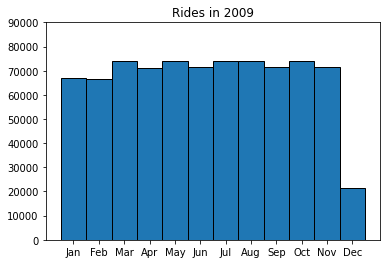

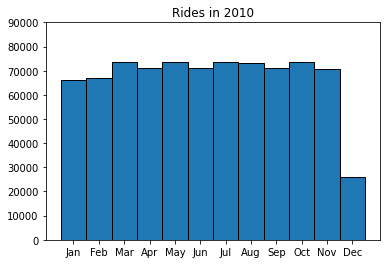

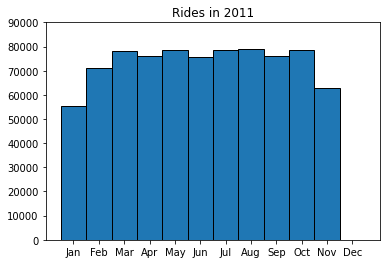

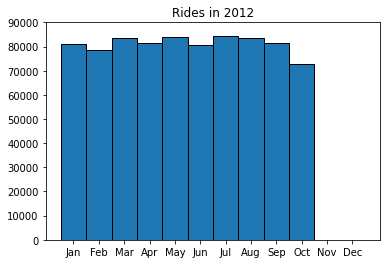

In [11]:
# Filter payment by cash
data = df.loc[df['payment_type'].str.upper() == 'CASH']

# Plot charts
top_limit = 90000
plotMonthlyDistributionByYear(data, 2009, top_limit)
plotMonthlyDistributionByYear(data, 2010, top_limit)
plotMonthlyDistributionByYear(data, 2011, top_limit)
plotMonthlyDistributionByYear(data, 2012, top_limit)

#4 - Tips

Make a time series chart computing the number of tips each day for the last 3 months of 2012.

In [12]:
# Get only rides of year 2012
data = df.loc[df['pickup_datetime'].dt.year  == 2012]
# Get the last three months (I know from the previous answer that the last month with data is october)
data = data.loc[data['pickup_datetime'].dt.month >= 8]
# Prepare to group by
data = data.assign(month_day=data['pickup_datetime'].dt.strftime('%m-%d'))
# Group by month/day and sum tips
data = data.groupby('month_day')['tip_amount'].sum().reset_index()

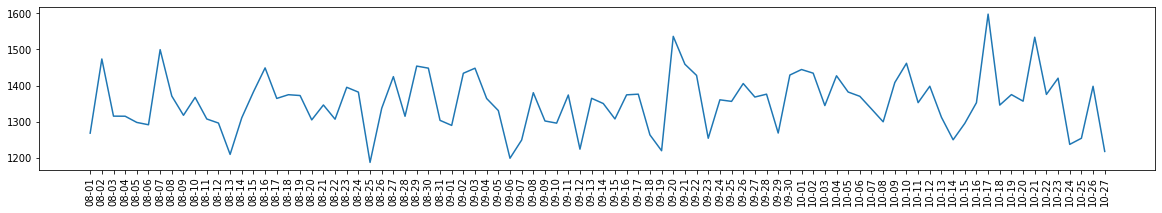

In [14]:
ax = plt.subplot(111)
ax.plot(data['month_day'], data['tip_amount'])
plt.xticks(rotation=90)
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

# 5 - Trips on Weekends

What is the average trip time on Saturdays and Sundays

In [15]:
# Filter trips to Saturdays(dayofweek=5) and Sundays(dayofweek=6)
data = df.loc[df['pickup_datetime'].dt.dayofweek >= 5]
# Get the trip time
data = data.assign(trip_time=data['dropoff_datetime']-data['pickup_datetime'])

In [16]:
# Get the average
avg = data['trip_time'].mean()
# Pretty print
hours, remainder = divmod(avg.seconds, 3600)
minutes, seconds = divmod(remainder, 60)
print('Average of %s minutes and %s seconds' % (minutes, seconds))

Average of 8 minutes and 44 seconds


# 6 - Seasonality

Analyze the data to find and prove seasonality

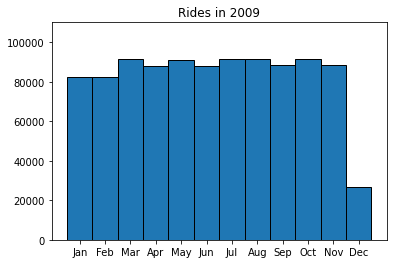

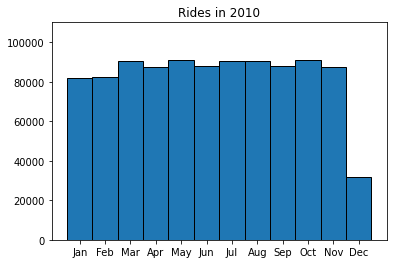

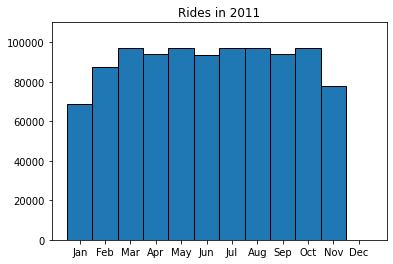

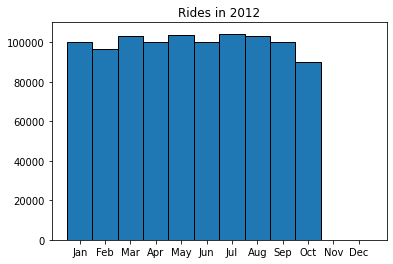

In [18]:
# Let's use the same charts of question 3 without the cash filtering 
top_limit = 110000
plotMonthlyDistributionByYear(df, 2009, top_limit)
plotMonthlyDistributionByYear(df, 2010, top_limit)
plotMonthlyDistributionByYear(df, 2011, top_limit)
plotMonthlyDistributionByYear(df, 2012, top_limit)

Although some data is missing in 2011 and 2012, we still can see that the number of rides decreases dramatically in December of 2009 and 2010.  We also see a significant decrease in January and February of 2009, 2010, and 2011. 

Note that these are the winter months in NYC. Probably, people tend to stay more at home in colder periods and, even more, in the holidays and winter breaks of December. 

# 8 - Fare amount

**Find what the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations**

Given the pickup and dropoff locations, we can get the trip distance. Luckily, this is already calculated in the original data. Hence, we can simply use the trip distance as the independent variable and the fare amount as the dependent one, which leads to a simple linear regression problem. However, before we start, let's do some pre-processing to elimate some weird data.

In [19]:
# Remove weird data
data = df.loc[df['trip_distance'] > 0]
data = data.loc[df['passenger_count'] > 0]

In [20]:
# Define the independent variable
X = data[['trip_distance']].values
# Define the dependent variable
y = data[['fare_amount']].values

In [21]:
# Split in train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [22]:
# Predict with linear regression
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
results = regressor.predict(X_test)

In [23]:
# Get the socre
regressor.score(X_test, y_test)

0.910336206281045

In [24]:
# Get the mean absolute error
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, results)

0.9836435409480211

In [35]:
regressor.intercept_

array([3.61509696])

In [33]:
regressor.coef_

array([[2.20388229]])

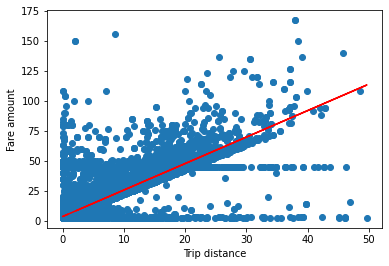

In [27]:
plt.scatter(X_test, y_test)
plt.xlabel('Trip distance')
plt.ylabel('Fare amount')
plt.plot(X_test, results, color = 'red')

Note that, we got a score of 0.91 with a simple linear algorithm approach, which indicates a strong relationship between the trip distance and the fare amount. Also, the mean absolute error shows that, on average, the prediction error is lower than one dollar (up or down). 

The formula to compute the fare amount is: 
  **3.61509696 + (2.20388229 * trip_distance)**

Finally, observing the scatter plot, we see that there is still room for improvement if we continue to analyze weird data (e.g., a trip distance close to 50 with fare amount close to zero).

# 9 - Map

**Make a latitude and longitude map view of pickups and dropoffs in the year 2010**

The extent of NYC is:
  West -74.257159 
  East -73.699215
  North 40.915568 
  South 40.495992

Ref: https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/nybb_metadata.pdf?ver=18c 

In [28]:
# Filter the year to 2010
data = df.loc[df['pickup_datetime'].dt.year == 2010]
# Filter to NYC extent
data = data.loc[data['pickup_latitude'].between(40.495992,40.915568)]
data = data.loc[data['pickup_longitude'].between(-74.257159,-73.699215)]
data = data.loc[data['dropoff_latitude'].between(40.495992,40.915568)]
data = data.loc[data['dropoff_longitude'].between(-74.257159,-73.699215)]

In [29]:
BBox = ( -74.257159, -73.699215, 40.495992, 40.915568)

In [31]:
ruh_m = plt.imread('https://github.com/elisasmenendez/ds-taxi-nyc/raw/master/map.png')

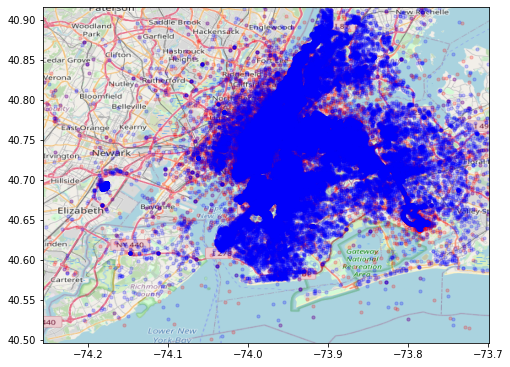

In [32]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(data.pickup_longitude, data.pickup_latitude, zorder=1, alpha= 0.2, c='r', s=10)
ax.scatter(data.dropoff_longitude, data.dropoff_latitude, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
